In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# Data Preprocessing

In [2]:
data = pd.read_csv('../data/data_train.csv', index_col=0)

# rename column and turn ot uint8
data.rename(columns={'Prediction': 'Rating'}, inplace=True)
data['Rating'] = data['Rating'].astype('uint8')

# get user and movie id by splitting index given in format rX_cY
data['UserId'] = data.index.str.split('_').str[0].str[1:].astype('int32')
data['MovieId'] = data.index.str.split('_').str[1].str[1:].astype('int32')

# subtract min UserId and MovieID to get indices starting at 0
data['UserId'] = data['UserId'] - data['UserId'].min()
data['MovieId'] = data['MovieId'] - data['MovieId'].min()

# make int again
data['UserId'] = data['UserId'].astype('int32')
data['MovieId'] = data['MovieId'].astype('int32')

# reorder columns to UserId, MovieId, Rating
data = data[['UserId', 'MovieId', 'Rating']]

# split into train and val data
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [46]:
train_data.head()

,UserId,MovieId,Rating
Id,,,
r5874_c663,5873,662,5
r4711_c367,4710,366,4
r2539_c435,2538,434,1
r7737_c558,7736,557,2
r9631_c791,9630,790,5


In [47]:
train_data.describe()

,UserId,MovieId,Rating
count,941561.000000,941561.000000,941561.000000
mean,5149.112369,482.580407,3.856588
std,2918.447452,274.174986,1.119108
min,0.000000,0.000000,1.000000
25%,2602.000000,246.000000,3.000000
50%,5247.000000,493.000000,4.000000
75%,7734.000000,690.000000,5.000000
max,9999.000000,999.000000,5.000000


In [3]:
normalize_by = "MovieId"

train_mean = train_data.groupby(by=normalize_by)['Rating'].mean()
train_std = train_data.groupby(by=normalize_by)['Rating'].std()
train_data.Rating = (train_data.Rating - train_mean.values[train_data[normalize_by]])/train_std.values[train_data[normalize_by]]

In [4]:
# function to get sparse matrix from data given as a dataframe with row and column indices
def get_sparse_matrix(data, n_rows, n_cols):
    return csr_matrix((data['Rating'].values, (data['UserId'].values, data['MovieId'].values)), shape=(n_rows, n_cols))

n_rows = train_data['UserId'].max() + 1 # might raise errors if in val set user with larger id
n_cols = train_data['MovieId'].max() + 1 # might raise errors if in val set movie with larger id
train_matrix = get_sparse_matrix(train_data, n_rows, n_cols)

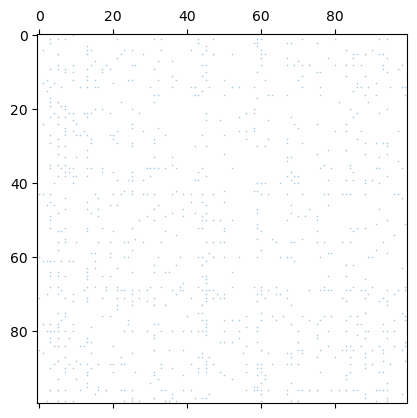

In [5]:
# plot sparse matrix
plt.spy(train_matrix[:100,:100], markersize=0.1)
plt.show()

# KNN

In [13]:
similarities = cosine_similarity(train_matrix.T, train_matrix.T)

In [62]:
def make_predictions(k, val_data, train_std, train_mean, max_elements=None):
    if max_elements is None:
        max_elements = val_data.shape[0]
    
    predictions = np.zeros(val_data.shape[0])
    for i in tqdm(range(max_elements)):
        user_id, movie_id = val_data.iloc[i][['UserId', 'MovieId']]

        user_id = int(user_id)
        movie_id = int(movie_id)

        rated_movies = train_matrix[user_id].nonzero()[1]
        nearest_movies = rated_movies[np.argsort(similarities[movie_id, rated_movies])[-k:]]
        prediction = train_matrix[user_id, nearest_movies].mean()
        predictions[i] = prediction * train_std[movie_id] + train_mean[movie_id]
    return np.rint(predictions)

# predictions = make_predictions(5, val_data, train_std, train_mean, 2)

In [66]:
max_elements = 10000

k_array = np.arange(1, 50, 5)
rmse_array = []

for k in k_array:
    predictions = make_predictions(k, val_data, train_std, train_mean, max_elements)
    rmse = mean_squared_error(val_data['Rating'][:max_elements], predictions[:max_elements], squared=False)
    rmse_array.append(rmse)

100%|██████████| 10000/10000 [00:07<00:00, 1414.29it/s]


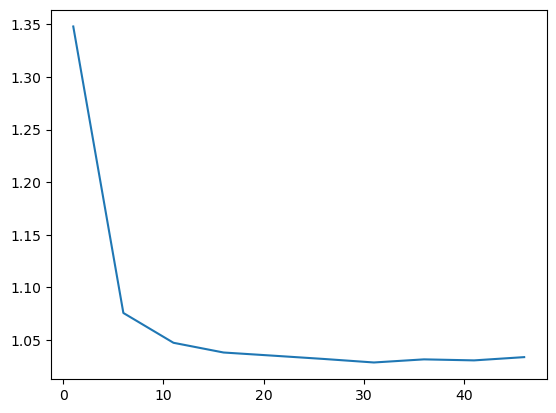

Best k: 31
Best RMSE: 1.0283968105745953


In [67]:
plt.plot(k_array, rmse_array)
plt.show()

print('Best k: {}'.format(k_array[np.argmin(rmse_array)]))
print('Best RMSE: {}'.format(np.min(rmse_array)))

In [68]:
best_k = k_array[np.argmin(rmse_array)]
# best_k = 5
predictions = make_predictions(best_k, val_data, train_std, train_mean)
val_data['Prediction'] = predictions

100%|██████████| 235391/235391 [02:44<00:00, 1427.29it/s]


In [64]:
val_data.head()

,UserId,MovieId,Rating,Prediction
Id,,,,
r5062_c706,5061,705,2,4.0
r9044_c148,9043,147,4,4.0
r1736_c169,1735,168,4,5.0
r5270_c877,5269,876,1,3.0
r6100_c691,6099,690,4,3.0


In [69]:
# compute rmse using sklearn
rmse_3 = mean_squared_error(val_data['Rating'], 3 * np.ones(val_data.shape[0]), squared=False)
rmse_mean_overall = mean_squared_error(val_data['Rating'], np.rint(train_mean.mean()) * np.ones(val_data.shape[0]), squared=False)
rmse_mean = mean_squared_error(val_data['Rating'], np.rint(train_mean[val_data.MovieId]), squared=False)
rmse_knn = mean_squared_error(val_data['Rating'], val_data['Prediction'], squared=False)
print('Dummy RMSE: {}'.format(rmse_3))
print('Mean RMSE: {}'.format(rmse_mean_overall))
print('Movie Mean RMSE: {}'.format(rmse_mean))
print('KNN RMSE: {}'.format(rmse_knn))

Dummy RMSE: 1.4112094086052875
Mean RMSE: 1.1275691757083937
Movie Mean RMSE: 1.0701981885501288
KNN RMSE: 1.0337088675643054


In [19]:
mean_squared_error(val_data['Rating'], train_mean[val_data.MovieId], squared=False)

1.0309495525701207